

# 552 Final Project
## Qinghui Xie
## USC ID: 7956658480

# Transfer Learning for Image Classification

## Data Exploration and Pre-processing


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


In [2]:
# uploading data to drive, will update to local data once completed
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
file_path_train = 'data/seg_train/'
file_path_test = 'data/seg_test/'


In [4]:
import os

classes = [class_name for class_name in os.listdir(file_path_train) 
           if os.path.isdir(os.path.join(file_path_train, class_name))]

image_paths = []
labels = []

for class_name in classes:
    class_path = os.path.join(file_path_train, class_name)
    for img in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_name)

image_paths = np.array(image_paths)
labels = np.array(labels)

# Train-validation split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=44
)

# One-hot encode labels
unique_classes = np.unique(labels)
class_indices = {class_name: i for i, class_name in enumerate(unique_classes)}

train_label_indices = np.array([class_indices[label] for label in train_labels])
val_label_indices = np.array([class_indices[label] for label in val_labels])

#image augumentations
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.7, 1.4],
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    file_path_test,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)



Found 11227 validated image filenames belonging to 6 classes.
Found 2807 validated image filenames belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
print("Class Indices (Train Generator):", train_generator.class_indices)
print("Class Indices (Test Generator):", test_generator.class_indices)


Class Indices (Train Generator): {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Class Indices (Test Generator): {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [6]:
from collections import Counter
print("Training Class Distribution:", Counter(train_generator.classes))
print("Validation Class Distribution:", Counter(val_generator.classes))
print("Test Class Distribution:", Counter(test_generator.classes))

Training Class Distribution: Counter({3: 2009, 2: 1923, 5: 1906, 4: 1819, 1: 1817, 0: 1753})
Validation Class Distribution: Counter({3: 503, 2: 481, 5: 476, 4: 455, 1: 454, 0: 438})
Test Class Distribution: Counter({2: 553, 3: 525, 4: 510, 5: 501, 1: 474, 0: 437})


In [7]:
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# agument training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  
    width_shift_range=0.1, 
    height_shift_range=0.1,
    zoom_range=0.1, 
    horizontal_flip=True,
    validation_split=0.2
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Add validation split
)
test_datagen = ImageDataGenerator(
    rescale=1./255)
$
# generate data for the different image sets
train_generator = train_datagen.flow_from_directory(
    file_path_train,
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical', #one hot encoding
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    file_path_train,
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical', #one hot encoding
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    file_path_test,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)
'''

"\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\n# agument training data\ntrain_datagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=20,  \n    width_shift_range=0.1, \n    height_shift_range=0.1,\n    zoom_range=0.1, \n    horizontal_flip=True,\n    validation_split=0.2\n)\nval_datagen = ImageDataGenerator(\n    rescale=1./255,\n    validation_split=0.2  # Add validation split\n)\ntest_datagen = ImageDataGenerator(\n    rescale=1./255)\n$\n# generate data for the different image sets\ntrain_generator = train_datagen.flow_from_directory(\n    file_path_train,\n    batch_size=32,\n    target_size=(128, 128),\n    class_mode='categorical', #one hot encoding\n    subset='training'\n)\n\nval_generator = val_datagen.flow_from_directory(\n    file_path_train,\n    batch_size=32,\n    target_size=(128, 128),\n    class_mode='categorical', #one hot encoding\n    subset='validation'\n)\n\ntest_generator = test_datagen.flow_from_directory(\n    file_pat

## Transfer Learning


In [8]:
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
input_shape = (150, 150, 3)
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

#freeze laters
for layer in base_model_ResNet50.layers:
    layer.trainable = False

# layers
x = GlobalAveragePooling2D()(base_model_ResNet50.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x) 
output = Dense(6, activation='softmax')(x) 

net50model = Model(inputs=base_model_ResNet50.input, outputs=output)
net50model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#train model
history = net50model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.7683 - auc: 0.9507 - loss: 3.1012 - precision: 0.8033 - recall: 0.7361 - val_accuracy: 0.8782 - val_auc: 0.9872 - val_loss: 0.7542 - val_precision: 0.8920 - val_recall: 0.8650
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.8501 - auc: 0.9823 - loss: 0.7424 - precision: 0.8691 - recall: 0.8308 - val_accuracy: 0.8896 - val_auc: 0.9877 - val_loss: 0.5462 - val_precision: 0.8992 - val_recall: 0.8771
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.8552 - auc: 0.9822 - loss: 0.6004 - precision: 0.8756 - recall: 0.8347 - val_accuracy: 0.8864 - val_auc: 0.9884 - val_loss: 0.4878 - val_precision: 0.8965 - val_recall: 0.8767
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.8563 - auc: 0.9843 - loss: 0.5380 - precision: 0.8769 - recall: 0.8385 - val_accuracy: 0.8871 - val_auc: 0.9883 - val_loss: 0.4804 - val_precision: 0.8957 - val_recall: 0.8807
Epoch 5/50
351/351 ━━━━━━━━━

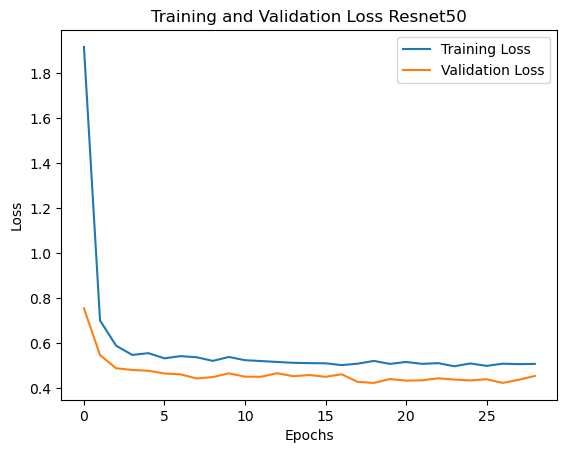

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Resnet50')
plt.show()

In [11]:
y_true = test_generator.classes  # Ground truth
y_pred = net50model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)
test_f1 = f1_score(y_true, y_pred_classes, average='weighted')

evaluation_results = net50model.evaluate(test_generator)
net50test_loss = evaluation_results[0]
net50test_accuracy = evaluation_results[1]
net50test_precision = evaluation_results[2]
net50test_recall = evaluation_results[3]
net50test_auc = evaluation_results[4]

net50metrics = {
    'Model': ['ResNet50'],
    'Test Accuracy': [net50test_accuracy],
    'Test Precision': [net50test_precision],
    'Test Recall': [net50test_recall],
    'Test AUC': [net50test_auc],
    'Test F1 Score': [test_f1]
}

results_df = pd.DataFrame(net50metrics)

94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 853ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 864ms/step - accuracy: 0.9039 - auc: 0.9905 - loss: 0.4059 - precision: 0.9155 - recall: 0.8967


In [ ]:
input_shape = (150, 150, 3)
base_model_ResNet101= ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

#freeze
for layer in base_model_ResNet101.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model_ResNet101.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
output = Dense(6, activation='softmax')(x)

net101model = Model(inputs=base_model_ResNet101.input, outputs=output)

net101model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = net101model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)



Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.7697 - auc: 0.9483 - loss: 3.1498 - precision: 0.8001 - recall: 0.7469 - val_accuracy: 0.8896 - val_auc: 0.9862 - val_loss: 0.7756 - val_precision: 0.9010 - val_recall: 0.8821
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 704s 2s/step - accuracy: 0.8590 - auc: 0.9827 - loss: 0.7400 - precision: 0.8784 - recall: 0.8427 - val_accuracy: 0.8864 - val_auc: 0.9875 - val_loss: 0.5461 - val_precision: 0.8956 - val_recall: 0.8771
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 707s 2s/step - accuracy: 0.8505 - auc: 0.9824 - loss: 0.6056 - precision: 0.8710 - recall: 0.8288 - val_accuracy: 0.8799 - val_auc: 0.9868 - val_loss: 0.5107 - val_precision: 0.8904 - val_recall: 0.8710
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.8537 - auc: 0.9831 - loss: 0.5581 - precision: 0.8727 - recall: 0.8353 - val_accuracy: 0.8885 - val_auc: 0.9880 - val_loss: 0.4700 - val_precision: 0.8997 - val_recall: 0.8792
Epoch 5/50
351/351 ━━━━━━━━━

In [ ]:
y_true = test_generator.classes  
y_pred = net101model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)


test_f1 = f1_score(y_true, y_pred_classes, average='weighted')

net101evaluation_results = net101model.evaluate(test_generator)
net101test_loss = net101evaluation_results[0]
net101test_accuracy = net101evaluation_results[1]
net101test_precision = net101evaluation_results[2]
net101test_recall = net101evaluation_results[3]
net101test_auc = net101evaluation_results[4]

net101metrics = {
    'Model': ['ResNet100'],
    'Test Accuracy': [net101test_accuracy],
    'Test Precision': [net101test_precision],
    'Test Recall': [net101test_recall],
    'Test AUC': [net101test_auc],
    'Test F1 Score': [test_f1]
}

results_df = pd.concat([results_df, pd.DataFrame(net101metrics)], ignore_index=True)
print(results_df)

94/94 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5587 - auc: 0.8742 - loss: 1.1929 - precision: 0.7586 - recall: 0.2013
       Model  Test Accuracy  Test Precision  Test Recall  Test AUC  \
0   ResNet50       0.559667        0.816245     0.204333  0.879871   
1  ResNet100       0.549667        0.745828     0.193667  0.868999   

   Test F1 Score  
0       0.159896  
1       0.153046  


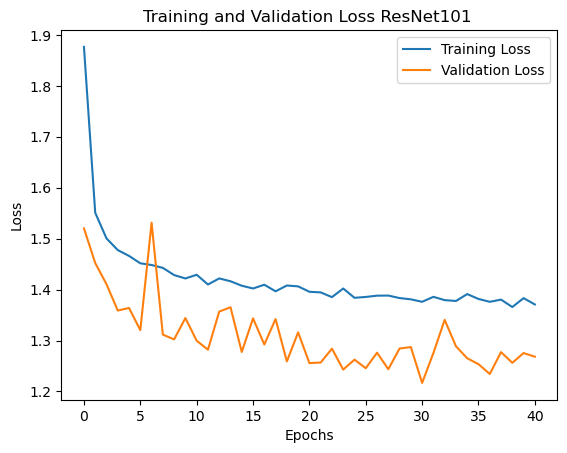

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss ResNet101 ')
plt.show()

In [ ]:
input_shape = (150, 150, 3)
base_model_ENetB0= EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model except 5
for layer in base_model_ENetB0.layers:
    layer.trainable = False

# layers
x = GlobalAveragePooling2D()(base_model_ENetB0.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)                   
output = Dense(6, activation='softmax')(x)  # Output for 6 classes

B0model = Model(inputs=base_model_ENetB0.input, outputs=output)

# Compile the model
B0model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# early stop
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = B0model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 154s 420ms/step - accuracy: 0.1804 - auc: 0.5205 - loss: 3.7927 - precision: 0.2912 - recall: 1.1507e-04 - val_accuracy: 0.1617 - val_auc: 0.5615 - val_loss: 2.9683 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 143s 406ms/step - accuracy: 0.2201 - auc: 0.6014 - loss: 2.7667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1984 - val_auc: 0.6135 - val_loss: 2.4138 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 142s 405ms/step - accuracy: 0.2576 - auc: 0.6593 - loss: 2.2411 - precision: 0.5714 - recall: 3.4176e-04 - val_accuracy: 0.1699 - val_auc: 0.6089 - val_loss: 2.1447 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 142s 405ms/step - accuracy: 0.2747 - auc: 0.6941 - loss: 1.9582 - precision: 0.4909 - recall: 0.0014 - val_accuracy: 0.3278 - val_auc: 0.7495 - val_loss: 1.7466 - val_precision: 0.66

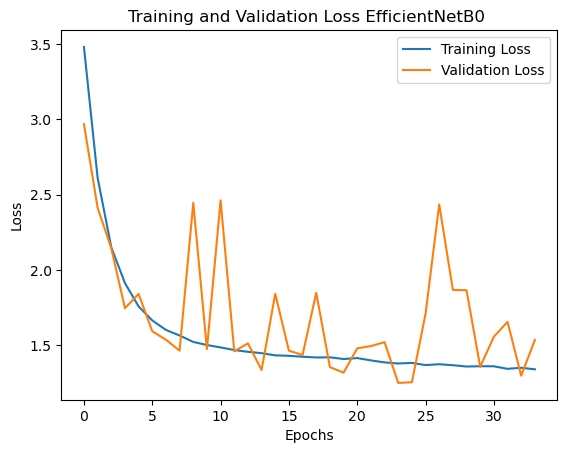

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss EfficientNetB0 ')
plt.show()

In [ ]:

y_true = test_generator.classes
y_pred = B0model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

test_f1 = f1_score(y_true, y_pred_classes, average='weighted')
Boevaluation_results = B0model.evaluate(test_generator)
B0test_loss = Boevaluation_results[0]
B0test_accuracy = Boevaluation_results[1]
B0test_precision = Boevaluation_results[2]
B0test_recall = Boevaluation_results[3]
B0test_auc = Boevaluation_results[4]

B0_metrics = {
    'Model': ['EfficientNetB0'],
    'Test Accuracy': [B0test_accuracy],
    'Test Precision': [B0test_precision],
    'Test Recall': [B0test_recall],
    'Test AUC': [B0test_auc],
    'Test F1 Score': [test_f1]
}



94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 290ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 272ms/step - accuracy: 0.5181 - auc: 0.8515 - loss: 1.2521 - precision: 0.6760 - recall: 0.1129


In [ ]:
results_df = pd.concat([results_df, pd.DataFrame(B0_metrics)], ignore_index=True)
display(results_df)

,Model,Test Accuracy,Test Precision,Test Recall,Test AUC,Test F1 Score
0,ResNet50,0.559667,0.816245,0.204333,0.879871,0.159896
1,ResNet100,0.549667,0.745828,0.193667,0.868999,0.153046
2,EfficientNetB0,0.511000,0.680312,0.116333,0.849979,0.168107


In [ ]:
input_shape = (150, 150, 3)
base_model_VGG= VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
#last layer not frozen
for layer in base_model_VGG.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model_VGG.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
output = Dense(6, activation='softmax')(x)

vggmodel = Model(inputs=base_model_VGG.input, outputs=output)

# Compile the model
vggmodel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = vggmodel.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping] 
)


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1396s 4s/step - accuracy: 0.5427 - auc: 0.8553 - loss: 1.7980 - precision: 0.6800 - recall: 0.4059 - val_accuracy: 0.8593 - val_auc: 0.9818 - val_loss: 0.4679 - val_precision: 0.8807 - val_recall: 0.8468
Epoch 2/50
259/351 ━━━━━━━━━━━━━━━━━━━━ 4:50 3s/step - accuracy: 0.8581 - auc: 0.9785 - loss: 0.4830 - precision: 0.8797 - recall: 0.8278

KeyboardInterrupt: 

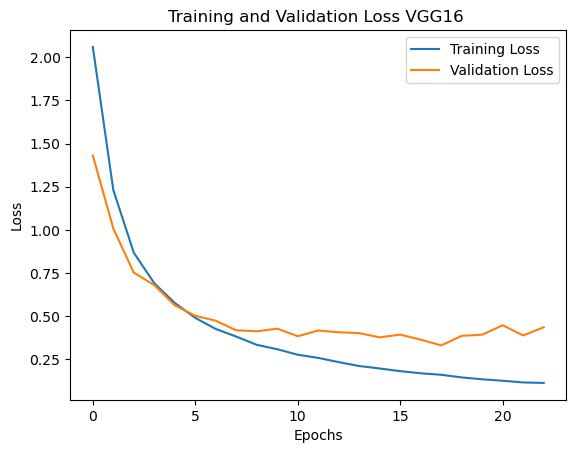

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss VGG16 ')
plt.show()

In [ ]:
y_true = test_generator.classes
y_pred = vggmodel.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

test_f1 = f1_score(y_true, y_pred_classes, average='weighted')
vggevaluation_results = vggmodel.evaluate(test_generator)
vggtest_loss = vggevaluation_results[0]
vggtest_accuracy = vggevaluation_results[1]
vggtest_precision = vggevaluation_results[2]
vggtest_recall = vggevaluation_results[3]
vggtest_auc = vggevaluation_results[4]



94/94 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.9173 - auc: 0.9888 - loss: 0.3224 - precision: 0.9179 - recall: 0.9164


In [ ]:
vgg_metrics = {
    'Model': ['VGG16'],
    'Test Accuracy': [vggtest_accuracy],
    'Test Precision': [vggtest_precision],
    'Test Recall': [vggtest_recall],
    'Test AUC': [vggtest_auc],
    'Test F1 Score': [test_f1]
}

results_df = pd.concat([results_df, pd.DataFrame(vgg_metrics)], ignore_index=True)


            Model  Test Accuracy  Test Precision  Test Recall  Test AUC  \
0        ResNet50       0.607667        0.809783     0.347667  0.900238   
1       ResNet100       0.529667        0.746445     0.210000  0.873153   
2  EfficientNetB0       0.410333        0.667391     0.102333  0.810609   
3           VGG16       0.918667        0.920683     0.917000  0.989958   

   Test F1 Score  
0       0.164096  
1       0.160199  
2       0.132987  
3       0.166862  


In [ ]:

display(results_df)

,Model,Test Accuracy,Test Precision,Test Recall,Test AUC,Test F1 Score
0,ResNet50,0.607667,0.809783,0.347667,0.900238,0.164096
1,ResNet100,0.529667,0.746445,0.210000,0.873153,0.160199
2,EfficientNetB0,0.410333,0.667391,0.102333,0.810609,0.132987
3,VGG16,0.918667,0.920683,0.917000,0.989958,0.166862


# Analysis

The VGG16 model significantly out performs the other models. This may be due to its complexity in nature. 
Some things I would like to note for this project:
I am currently running the models on a M1 Macbook Air and it is a few years old. I've exhausted all of my Colab computing credits and there was no other way for me to run the models and tune them in the projected time. This final run took more than 20 hours to complete and it wasn't feasible for me to fine tune further given the deadline. 
If I had a faster GPU, here are some things that I would do.
- Input the image at the size 224 x 224. I made my images smaller for a faster runtime and even with the scaled time images, it took a long time to run. I believe having a less pixelated image will help the models with training and validation accuracy. 
- I would increase the epochs and decrease the batch size. 
- I would like to play around with the number of neurons (128, 256, or 512) for the layers along with the learning rate. After running the models for 20 epochs to test, I stayed on the middle ground but if given a better machine, I would fine tune it even further. 

I hope you would acknowledge my efforts even though the test accuracies weren't very high. 